# How does the taxonomic distribution of contigs differ by soil layer (mineral vs organic) in Colorado?

This notebook uses the NMDC API endpoints to explore how the taxononomic distribution of metagenome contigs differ by the mineral and organic soil layers in Colorado. It involves 9 API requests to reach the scaffold lineage TSV data objects in order to analyze the taxanomic distribution. Iterating through the TSV files includes 100+ API calls to get the necessary taxonomic counts and is time consuming. 

In [1]:
# Load essential libraries
library(jsonlite, warn.conflicts=FALSE)
library(dplyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)
library(readr, warn.conflicts=FALSE)
library(ggplot2, warn.conflicts=FALSE)

if(Sys.getenv("COLAB_BACKEND_VERSION") == "") source("../../utility_functions.R")

if(Sys.getenv("COLAB_BACKEND_VERSION") != "") source("http://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/utility_functions.R")

# 1. Get all biosamples where soil_horizon exists and the geo_loc_name has "Colorado" in the name

The first step in answering how the taxonomic distribution of contigs differ by soil layer is to get a list of all the biosamples that have metadata for soil_horizon and a string matching "Colorado, Rocky Mountains" for the geo_loc_name. We use the `get_all_results` function (defined in `utility_functions.R`) to do this. We query the biosample_set collection with a mongo-like filter of `{"soil_horizon":{"$exists": true}, "geo_loc_name.has_raw_value": {"$regex": "Colorado"}}`, a maximum page size of 100, and specifying that we want three fields returned id, soil_horizon, and geo_loc_name. Note that id is always returned. Since we will be joining the results of multiple API requests with a field of id for different collections, we can change the name of the id key to be more explicit - calling it biosample_id instead.

In [2]:
# Get biosamples using get_all_results function
biosample_df <- get_all_results(
    collection = 'biosample_set', 
    filter_text = '{"soil_horizon":{"$exists": true}, "geo_loc_name.has_raw_value": {"$regex": "Colorado"}}', 
    max_page_size = 100, 
    fields = 'id,soil_horizon,geo_loc_name'
    )

# Clarify the column names
biosample_df <- biosample_df %>%
    unnest(cols = geo_loc_name, names_sep = "_") %>% 
    rename(biosample_id = id,
           geo_loc_name = geo_loc_name_has_raw_value)
head(biosample_df)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type
<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue


# 2. Get all Pooling results where the Pooling `has_input` are the biosample ids

We use the `get_results_by_id` function to get a list of all pooling results whose `has_input` values are any of the `biosample_id`s we retrieved in step 1. After, the pooling results are unnested to a flat data frame, and the names are cleaned up so it is clear which collection the results are from. Because `Pooling` is a subclass of `MaterialProcessing` the pooling records are found in the `material_processing_set`.

In [3]:
pooling_df <- get_results_by_id(
    collection = 'material_processing_set',
    match_id_field = 'has_input',
    id_list = biosample_df$biosample_id,
    fields = 'id,has_input,has_output',
    max_page_size = 20
)

# Unnest the has_input and has_output columns, get unique results, and rename the columns.
pooling_df2 <- pooling_df %>%
    unnest(cols = c(has_input, has_output), names_sep = "_") %>%
    distinct() %>%
    rename(pooling_id = id,
           biosample_id = has_input,
           pooling_has_output = has_output)
head(pooling_df2)

pooling_id,biosample_id,pooling_has_output
<chr>,<chr>,<chr>
nmdc:extrp-11-bm4gp651,nmdc:bsm-11-0f43ab20,nmdc:procsm-11-6x9hd461
nmdc:extrp-11-kxh7ex80,nmdc:bsm-11-0r62mq05,nmdc:procsm-11-60vf4k79
nmdc:extrp-11-mkhbfr22,nmdc:bsm-11-1frj0t76,nmdc:procsm-11-nzvht045
nmdc:extrp-11-ysq0cv31,nmdc:bsm-11-1481pt52,nmdc:procsm-11-pvskrs02
nmdc:poolp-11-0xm4qn65,nmdc:bsm-11-0yw1rj05,nmdc:procsm-11-vqjw0h14
nmdc:poolp-11-0xm4qn65,nmdc:bsm-11-5wwh4520,nmdc:procsm-11-vqjw0h14


Merge the biosample and pooling dataframes together to get a dataframe with biosample and pooling data.

In [4]:
biosample_df2 <- left_join(biosample_df, pooling_df2, by = 'biosample_id')
head(biosample_df2)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,pooling_has_output
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-5s07gt34
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-ez7edj21
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-y8w3sk61
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-258vbz70
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:extrp-11-bm4gp651,nmdc:procsm-11-6x9hd461


From the `pooling_has_output` IDs (all starting with *"nmdc:procsm"*), we can tell that the output from the pooling step is a `ProcessedSample`.  Therefore, we will rename the column from `pooling_has_output` to `processed_sample_id`. 

In [5]:
biosample_df3 <- biosample_df2 %>%
    rename(processed_sample_id = pooling_has_output) 
head(biosample_df3)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-5s07gt34
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-ez7edj21
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-y8w3sk61
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-258vbz70
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:extrp-11-bm4gp651,nmdc:procsm-11-6x9hd461


# 3. Get `Extraction` records where `processed_sample_id` identifier is the `has_input` to the `Extraction`

The `get_id_results` function is used, again (you can see the pattern), again querying the `material_processing_set` (because `Extraction` records are also a subclass of `MaterialProcessing` using the `processed_sample1` identifier as the `has_input` for the `material_processing_set`. The resulting dataframe is unnested and the names are adjusted to make it clear which set the inputs, outputs, and ids are from.

In [6]:
extraction_df <- get_results_by_id(
    collection = 'material_processing_set',
    match_id_field = 'has_input',
    id_list = unique(biosample_df3$processed_sample_id),
    fields = 'id,has_input,has_output',
    max_page_size = 20
)

extraction_df <- extraction_df %>%
    unnest(cols = c(has_input, has_output), names_sep = "_") %>%
    distinct() %>%
    rename(extraction_id = id,
           processed_sample_id = has_input,
           extraction_has_output = has_output)
head(extraction_df)

processed_sample_id,extraction_has_output,extraction_id
<chr>,<chr>,<chr>
nmdc:procsm-11-kngzyt90,nmdc:procsm-11-h9s7h174,nmdc:extrp-11-v25scb12
nmdc:procsm-11-mr5hf033,nmdc:procsm-11-7qy2y664,nmdc:extrp-11-gnvf5s35
nmdc:procsm-11-33n4p085,nmdc:procsm-11-6xc6vy98,nmdc:extrp-11-j5qc7973
nmdc:procsm-11-2fxf0e98,nmdc:procsm-11-x763xr38,nmdc:extrp-11-y5ewyv43
nmdc:procsm-11-y8w3sk61,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92
nmdc:procsm-11-5s07gt34,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21


Merge the extraction data with the biosample, pooling, and processed sample data

In [7]:
biosample_df4 <- biosample_df3 %>%
    left_join(extraction_df, by = join_by(processed_sample_id))
head(biosample_df4)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id,extraction_has_output,extraction_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-5s07gt34,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-ez7edj21,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-y8w3sk61,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-258vbz70,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:extrp-11-bm4gp651,nmdc:procsm-11-6x9hd461,nmdc:procsm-11-merw2c87,nmdc:libprp-11-r1y1vd21


From the `extraction_has_output` IDs (all starting with *"nmdc:procsm"*), we can tell that the output from the extraction step is a `ProcessedSample`.  Therefore, we will rename the column from `extraction_has_output` to `processed_sample_id2`. 

In [8]:
biosample_df5 <- biosample_df4 %>%
    rename(processed_sample_id2 = extraction_has_output)
head(biosample_df5)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id,processed_sample_id2,extraction_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-5s07gt34,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-ez7edj21,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-y8w3sk61,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-258vbz70,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:extrp-11-bm4gp651,nmdc:procsm-11-6x9hd461,nmdc:procsm-11-merw2c87,nmdc:libprp-11-r1y1vd21


# 4. Get the `LibraryPreparation` records

Using the `processed_sample_id2` identifiers from the last query as the `has_input` again for the the `material_processing_set` (because `LibraryPreparation` is a subclass of `MaterialProcessing`), we get a new batch of results, returning the library preparation identifiers, inputs and outputs. The results is unnested and names are clarified to demonstrate they are associated with `LibraryPreparation` records.

In [9]:
library_prep_df <- get_results_by_id(
    collection = 'material_processing_set',
    match_id_field = 'has_input',
    id_list = unique(biosample_df5$processed_sample_id2),
    fields = 'id,has_input,has_output',
    max_page_size = 20
)

library_prep_df <- library_prep_df %>%
    unnest(cols = c(has_input,has_output), names_sep = "_") %>%
    distinct() %>%
    rename(library_preparation_id = id,
           processed_sample_id2 = has_input,
           library_preparation_has_output = has_output)
head(library_prep_df)

processed_sample_id2,library_preparation_has_output,library_preparation_id
<chr>,<chr>,<chr>
nmdc:procsm-11-7qy2y664,nmdc:procsm-11-wd4s5f38,nmdc:libprp-11-wv6p0032
nmdc:procsm-11-x763xr38,nmdc:procsm-11-9ghwha16,nmdc:libprp-11-gasf6t26
nmdc:procsm-11-h9s7h174,nmdc:procsm-11-4z512838,nmdc:libprp-11-t70f6032
nmdc:procsm-11-6xc6vy98,nmdc:procsm-11-44e5ds31,nmdc:libprp-11-8bzn7n07
nmdc:procsm-11-q086v208,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35
nmdc:procsm-11-1qgqxz62,nmdc:procsm-11-hxfxnz83,nmdc:libprp-11-6zgrcr81


Merge the library preparation data with the biosample, pooling, processed sample, extraction, and processed sample data

In [10]:
biosample_df6 <- biosample_df5 %>%
    left_join(library_prep_df, by = join_by(processed_sample_id2))
head(biosample_df6)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id,processed_sample_id2,extraction_id,library_preparation_has_output,library_preparation_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-5s07gt34,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-ez7edj21,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-y8w3sk61,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-258vbz70,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244,nmdc:procsm-11-t397mj03,nmdc:libprp-11-p07zpd31
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:extrp-11-bm4gp651,nmdc:procsm-11-6x9hd461,nmdc:procsm-11-merw2c87,nmdc:libprp-11-r1y1vd21,NA,NA


Again, from the `library_preparation_has_output` IDs (all starting with *"nmdc:procsm"*), we can tell that the output to the library preparation step is a `ProcessedSample`.  Therefore, we will rename the column from `library_preparation_has_output` to `processed_sample_id3`. |

In [11]:
biosample_df7 <- biosample_df6 %>%
    rename(processed_sample_id3 = library_preparation_has_output)
head(biosample_df7)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-5s07gt34,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-ez7edj21,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-y8w3sk61,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-258vbz70,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244,nmdc:procsm-11-t397mj03,nmdc:libprp-11-p07zpd31
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:extrp-11-bm4gp651,nmdc:procsm-11-6x9hd461,nmdc:procsm-11-merw2c87,nmdc:libprp-11-r1y1vd21,NA,NA


# 5. Get `NucleotideSequencing` records from the processed sample identifiers

Using the third batch of processed sample identifiers, we query the `data_generation_set` on the `has_input` field to retreive `NucleotideSequencing` record (because `NucleotideSequencing` is a subclass of `DataGeneration`). The `id` and `has_input` field names are changed to specify that they came from the `NucleotideSequencing` records.

In [12]:
data_generation_df <- get_results_by_id(
    collection = 'data_generation_set',
    match_id_field = 'has_input',
    id_list = unique(biosample_df7$processed_sample_id3),
    fields = 'id,has_input',
    max_page_size = 20
)

data_generation_df <- data_generation_df %>%
    unnest(cols = c(has_input), names_sep = "_") %>%
    rename(data_generation_id = id,
           processed_sample_id3 = has_input)
head(data_generation_df)

processed_sample_id3,data_generation_id
<chr>,<chr>
nmdc:procsm-11-43n6yz70,nmdc:omprc-11-g1n61y55
nmdc:procsm-11-44e5ds31,nmdc:dgns-11-ekte1238
nmdc:procsm-11-4jj6k690,nmdc:omprc-11-yt96hb84
nmdc:procsm-11-4z512838,nmdc:omprc-11-afejca38
nmdc:procsm-11-7cpyc435,nmdc:omprc-11-by9r5p41
nmdc:procsm-11-9ghwha16,nmdc:omprc-11-bd1eyb41


Merge the data generation records with the biosample, pooling, processed sample, extraction, processed sample, library preparation, and processed sample records.

In [13]:
biosample_df8 <- biosample_df7 %>%
    left_join(data_generation_df, by = join_by(processed_sample_id3))
head(biosample_df8)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id,data_generation_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-5e2asm75,nmdc:procsm-11-5s07gt34,nmdc:procsm-11-edpstj65,nmdc:extrp-11-76s2tz21,nmdc:procsm-11-tq69qx97,nmdc:libprp-11-pqjwcw60,nmdc:omprc-11-769ab655
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:TextValue,nmdc:poolp-11-qq41ss20,nmdc:procsm-11-ez7edj21,nmdc:procsm-11-p09rbx50,nmdc:extrp-11-faz6a041,nmdc:procsm-11-v7s6qh96,nmdc:libprp-11-4qwse385,nmdc:omprc-11-597mc608
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-pak1ws91,nmdc:procsm-11-y8w3sk61,nmdc:procsm-11-q086v208,nmdc:extrp-11-9qd5ke92,nmdc:procsm-11-jkvhv341,nmdc:libprp-11-24s1rh35,nmdc:dgns-11-j3w06312
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:TextValue,nmdc:poolp-11-vfkwpy98,nmdc:procsm-11-258vbz70,nmdc:procsm-11-nrrknt87,nmdc:extrp-11-qg3zf244,nmdc:procsm-11-t397mj03,nmdc:libprp-11-p07zpd31,nmdc:dgns-11-jxh3ht55
nmdc:bsm-11-0f43ab20,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:extrp-11-bm4gp651,nmdc:procsm-11-6x9hd461,nmdc:procsm-11-merw2c87,nmdc:libprp-11-r1y1vd21,NA,NA,NA


# 6. Get the `MetagenomeAnnotation` ids using the `DataGeneration` identifiers

The `workflow_execution_set` is queried to retrieve `MetagenomeAnnotation` records (because `MetagenomeAnnotation` is a subclass of `WorkflowExecution`) using the identifiers obtained from the data generation to match with the `was_informed_by` field in the `workflow_execution_set`. Field names are clarified, once again to specify the collection they came from.

In [14]:
metagenome_annotation_df <- get_results_by_id(
    collection = 'workflow_execution_set',
    match_id_field = 'was_informed_by',
    id_list = unique(biosample_df8$data_generation_id),
    fields = 'id,was_informed_by,has_output,type',
    max_page_size = 20
)
head(metagenome_annotation_df)

,id,type,has_output,was_informed_by
,<chr>,<chr>,<list>,<list>
1,nmdc:wfmag-11-2araz898.1,nmdc:MagsAnalysis,"nmdc:dobj-11-qcjne029, nmdc:dobj-11-v6v4az06, nmdc:dobj-11-99ze1q07, nmdc:dobj-11-82mxmg53, nmdc:dobj-11-tdk66274, nmdc:dobj-11-x0k49271, nmdc:dobj-11-hv9we043, nmdc:dobj-11-hbmfj707, nmdc:dobj-11-970hbm36",nmdc:omprc-11-63ajbd04
2,nmdc:wfmag-11-3pdsac32.1,nmdc:MagsAnalysis,"nmdc:dobj-11-bjarz597, nmdc:dobj-11-5sa1hc37, nmdc:dobj-11-ypaebx18, nmdc:dobj-11-f4v00f74, nmdc:dobj-11-pgtn0f33, nmdc:dobj-11-ftexk841, nmdc:dobj-11-v80h9572, nmdc:dobj-11-rcrgkr35, nmdc:dobj-11-13a4c730",nmdc:dgns-11-j3w06312
3,nmdc:wfmag-11-6beb5p13.1,nmdc:MagsAnalysis,"nmdc:dobj-11-te4k2925, nmdc:dobj-11-7n3mbm30, nmdc:dobj-11-804v6747, nmdc:dobj-11-rfr5yn37, nmdc:dobj-11-7mb5fc28, nmdc:dobj-11-9tmx4w60, nmdc:dobj-11-6b2ytn94, nmdc:dobj-11-meg6gk11, nmdc:dobj-11-m78rp150",nmdc:dgns-11-jxh3ht55
4,nmdc:wfmag-11-7628dd79.1,nmdc:MagsAnalysis,"nmdc:dobj-11-y1es6k19, nmdc:dobj-11-2542ex33, nmdc:dobj-11-8zz56n07, nmdc:dobj-11-av2mf726, nmdc:dobj-11-8bega838, nmdc:dobj-11-t551g482, nmdc:dobj-11-vkd6b435, nmdc:dobj-11-5zkkqt82, nmdc:dobj-11-rrn00m11",nmdc:dgns-11-ekte1238
5,nmdc:wfmag-11-94b5df26.2,nmdc:MagsAnalysis,"nmdc:dobj-11-2bqtt266, nmdc:dobj-11-h5dvmy54, nmdc:dobj-11-kym9yb67, nmdc:dobj-11-sr82ew48, nmdc:dobj-11-vsczzw39, nmdc:dobj-11-2vzahp17, nmdc:dobj-11-2s7gaj21, nmdc:dobj-11-amk45957, nmdc:dobj-11-mxwdb762",nmdc:omprc-11-by9r5p41
6,nmdc:wfmag-11-cm083360.1,nmdc:MagsAnalysis,"nmdc:dobj-11-e0yx0q42, nmdc:dobj-11-tck6r019, nmdc:dobj-11-chb8vp93, nmdc:dobj-11-8btvvx22, nmdc:dobj-11-4bd1fc55, nmdc:dobj-11-kzfgm705, nmdc:dobj-11-6rb0nx36, nmdc:dobj-11-ygjp4894, nmdc:dobj-11-8bx5z929",nmdc:omprc-11-769ab655


This query resulted in all the workflows associated with the `DataGeneration` identifiers.  We can investigate the different types of workflows assoaciated below.

In [15]:
unique(metagenome_annotation_df$type)

[1] "nmdc:MagsAnalysis"              "nmdc:MetagenomeAnnotation"     
[3] "nmdc:MetagenomeAssembly"        "nmdc:ReadBasedTaxonomyAnalysis"
[5] "nmdc:ReadQcAnalysis"            "nmdc:MetagenomeSequencing"

We are only interested in the outputs of the `MetagenomeAnnotation` workflow, so we'll filter our dataframe to only these results and clean it up for the next step

In [16]:
metagenome_annotation_df <- metagenome_annotation_df %>%
    filter(type == "nmdc:MetagenomeAnnotation") %>%
    unnest(
        cols = c(
            was_informed_by,
            has_output
        ), names_sep = "_") %>%
    rename(metagenome_annotation_id = id,
           data_generation_id = was_informed_by,
           matagenome_annotation_has_output = has_output,
           workflow_type = type)
head(metagenome_annotation_df)

metagenome_annotation_id,workflow_type,matagenome_annotation_has_output,data_generation_id
<chr>,<chr>,<chr>,<chr>
nmdc:wfmgan-11-05cdqw41.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-ndsyd761,nmdc:dgns-11-ekte1238
nmdc:wfmgan-11-05cdqw41.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-ss1k0e30,nmdc:dgns-11-ekte1238
nmdc:wfmgan-11-05cdqw41.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-m5g68x38,nmdc:dgns-11-ekte1238
nmdc:wfmgan-11-05cdqw41.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-22449330,nmdc:dgns-11-ekte1238
nmdc:wfmgan-11-05cdqw41.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-t33sqd79,nmdc:dgns-11-ekte1238
nmdc:wfmgan-11-05cdqw41.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-ykw2tv02,nmdc:dgns-11-ekte1238


Merge the metagenome annotation data with the biosample, pooling, processed sample, extraction, processed sample, library preparation, processed sample, data generation, and processed sample data.

In [17]:
biosample_df9 <- biosample_df8 %>%
    left_join(metagenome_annotation_df, by = join_by(data_generation_id), relationship = "many-to-many")
head(biosample_df9)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id,data_generation_id,metagenome_annotation_id,workflow_type,matagenome_annotation_has_output
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-0nmx9476
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-jqtxmn44
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-xhrek759
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-hcgzc591
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-er6q4n72
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-jg6awk48


# 7. Get data objects from the metagenome activity result outputs

We query the `data_object_set` using the `metagenome_annotation_has_output` identifiers to match the `id` field in the data objects. We then filter the results for only those results with a `data_object_type` of `Scaffold Lineage tsv` (since this has contig taxonomy results). Note that the `url` is a new field returned that contains the tsvs we will need for the final analysis.

In [18]:
data_object_df <- get_results_by_id(
    collection = 'data_object_set',
    match_id_field = 'id',
    id_list = unique(biosample_df9$matagenome_annotation_has_output),
    fields = 'id,data_object_type,url',
    max_page_size = 50
)

# Filter the data object results to only include the Scaffold Lineage tsv files
data_object_df <- data_object_df %>%
    rename(data_object_id = id) %>%
    filter(data_object_type == 'Scaffold Lineage tsv')
head(data_object_df)

,data_object_id,data_object_type,url
,<chr>,<chr>,<chr>
1,nmdc:dobj-11-f0shbt75,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-769ab655/nmdc:wfmgan-11-zk5aec25.1/nmdc_wfmgan-11-zk5aec25.1_scaffold_lineage.tsv
2,nmdc:dobj-11-jg6awk48,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-63ajbd04/nmdc:wfmgan-11-canf7544.1/nmdc_wfmgan-11-canf7544.1_scaffold_lineage.tsv
3,nmdc:dobj-11-jp45gr33,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
4,nmdc:dobj-11-mmv19z03,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.2/nmdc_wfmgan-11-3s20yk38.2_scaffold_lineage.tsv
5,nmdc:dobj-11-bzzn7310,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:dgns-11-jxh3ht55/nmdc:wfmgan-11-nk9mgk94.1/nmdc_wfmgan-11-nk9mgk94.1_scaffold_lineage.tsv
6,nmdc:dobj-11-zv2esq19,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:dgns-11-j3w06312/nmdc:wfmgan-11-5bvrev52.1/nmdc_wfmgan-11-5bvrev52.1_scaffold_lineage.tsv


Merge the data object data with the biosample, pooling, processed sample, extraction, processed sample, library preparation, processed sample, data generation, processed sample, and metagenome annotation data

In [19]:
biosample_df10 <- biosample_df9 %>%
    rename(data_object_id = matagenome_annotation_has_output) %>%
    left_join(data_object_df, by = join_by(data_object_id))
head(biosample_df10)

biosample_id,soil_horizon,geo_loc_name,geo_loc_name_type,pooling_id,processed_sample_id,processed_sample_id2,extraction_id,processed_sample_id3,library_preparation_id,data_generation_id,metagenome_annotation_id,workflow_type,data_object_id,data_object_type,url
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-0nmx9476,NA,NA
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-jqtxmn44,NA,NA
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-xhrek759,NA,NA
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-hcgzc591,NA,NA
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-er6q4n72,NA,NA
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:TextValue,nmdc:poolp-11-gxv2dy50,nmdc:procsm-11-ytthx235,nmdc:procsm-11-cd8pg312,nmdc:extrp-11-c0kyyp83,nmdc:procsm-11-jrykhg31,nmdc:libprp-11-2szbj346,nmdc:omprc-11-63ajbd04,nmdc:wfmgan-11-canf7544.1,nmdc:MetagenomeAnnotation,nmdc:dobj-11-jg6awk48,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-63ajbd04/nmdc:wfmgan-11-canf7544.1/nmdc_wfmgan-11-canf7544.1_scaffold_lineage.tsv


## Clean up the combined results

In the final step of retrieving and cleaning the data, we clean up the final merged data frame by removing all of the "joining columns" that are not needed in our final analysis. Because some of the biosamples were pooled, we only retain unique url results (and drop the `biosample_id` column). The only columns we retain are the `soil_horizon`, `geo_loc_name`, and the `url` to the tsv. The `final_df` is displayed.

In [20]:
biosample_df_final <- biosample_df10 %>%
    select(biosample_id, soil_horizon, geo_loc_name, data_object_id, data_object_type, url) %>%
    distinct() %>%
    filter(!is.na(url))
head(biosample_df_final)

biosample_id,soil_horizon,geo_loc_name,data_object_id,data_object_type,url
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-00m15h97,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:dobj-11-jg6awk48,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-63ajbd04/nmdc:wfmgan-11-canf7544.1/nmdc_wfmgan-11-canf7544.1_scaffold_lineage.tsv
nmdc:bsm-11-06ta8e31,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:dobj-11-f0shbt75,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-769ab655/nmdc:wfmgan-11-zk5aec25.1/nmdc_wfmgan-11-zk5aec25.1_scaffold_lineage.tsv
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:dobj-11-jp45gr33,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.1/nmdc_wfmgan-11-3s20yk38.1_scaffold_lineage.tsv
nmdc:bsm-11-06tgpb52,O horizon,"USA: Colorado, Rocky Mountains",nmdc:dobj-11-mmv19z03,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:omprc-11-597mc608/nmdc:wfmgan-11-3s20yk38.2/nmdc_wfmgan-11-3s20yk38.2_scaffold_lineage.tsv
nmdc:bsm-11-0asn5d63,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:dobj-11-zv2esq19,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:dgns-11-j3w06312/nmdc:wfmgan-11-5bvrev52.1/nmdc_wfmgan-11-5bvrev52.1_scaffold_lineage.tsv
nmdc:bsm-11-0djp2e45,M horizon,"USA: Colorado, North Sterling",nmdc:dobj-11-bzzn7310,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:dgns-11-jxh3ht55/nmdc:wfmgan-11-nk9mgk94.1/nmdc_wfmgan-11-nk9mgk94.1_scaffold_lineage.tsv


## Show how many results have M horizon vs. O horizon

The `soil_horizon` column can be counted using the `count()` functionality. There are many more samples with associated Scaffold Lineage tsvs from a M horizon biosample than a O horizon.

In [21]:
biosample_df_final %>%
    count(soil_horizon)

soil_horizon,n
<chr>,<int>
M horizon,454
O horizon,107


## Example of what the TSV contig taxa file looks like

A snippet of the TSV file we need to iterate over to get the taxa abundance for the contigs is shown below. The third column is the initial count for the taxa, where each row is `1.0`. However, there are duplicate rows of taxa, meaning there are actually more than `1.0` for several taxa (though they appear as duplicate rows with `1.0` as the count`). We will take this into consideration when we calculate the relative abundance for each taxa.

In [22]:
url <- biosample_df_final$url[1]

# Read the TSV file
contig_taxa_df <- read_tsv(url, col_names = FALSE, show_col_types = FALSE)

# Add column names 
colnames(contig_taxa_df) <- c('contig_id', 'taxa', 'initial_count')

# Show the first few rows
head(contig_taxa_df)

contig_id,taxa,initial_count
<chr>,<chr>,<dbl>
nmdc:wfmgan-11-canf7544.1_00001,Bacteria;Actinomycetota;Actinomycetes,0.75
nmdc:wfmgan-11-canf7544.1_00002,Bacteria;Actinomycetota;Actinomycetes,0.75
nmdc:wfmgan-11-canf7544.1_00003,Bacteria;Actinomycetota;Actinomycetes,1.00
nmdc:wfmgan-11-canf7544.1_00004,Bacteria;Actinomycetota;Actinomycetes,1.00
nmdc:wfmgan-11-canf7544.1_00005,Bacteria;Actinomycetota;Actinomycetes,1.00
nmdc:wfmgan-11-canf7544.1_00006,Bacteria;Actinomycetota;Actinomycetes;Kitasatosporales;Streptomycetaceae;Streptomyces,0.75


## Randomly select a subset of samples for which to download taxonomy files

As more data is added to NMDC, downloading all of the results that meet the criteria for this notebook becomes a larger and slower task. Here we will randomly sample a set number of datasets from each horizon to use for the rest of the notebook to improve performance.

In [24]:
urls <- biosample_df_final %>%
  distinct(url, .keep_all = TRUE) %>%
  group_by(soil_horizon) %>%
  slice_sample(n = 50) %>%
  ungroup() %>%
  pull(url)

## Iterate throught the TSVs to get the contig taxa information

Using the readr's `read_tsv` function, the TSV urls can be iterated over gathering the taxa information. The TSVs are converted into dataframes where they are manipulated to suit the data structure needed. The columns are given names and the taxa column is split into a proper list (instead of a string of items separated by a semicolon ;). The third element from the list of taxa is retrieved to get only the phylum level information of the taxa (or unknown to the highest available taxon). A grouping function is performed on the `taxa` column and the `count()` functionality is used to calculate the count for how many times each taxa occurs, which is then used to calculate the relative abundance of each taxa for each sample. 

Any errors in requesting the TSV urls are collected as a dictionary, so we can either try to query them again, or look into why they were not able to be collected. 

In [25]:
#urls <- unique(biosample_df_final$url)
results_list <- c()
error_dict <- list()

for (i in 1:length(urls)) {
    # if i a factor of 100, print the progress
    if (i %% 10 == 0) {
        print(paste('Processing', i, 'of', length(urls)))
    }
    url <- urls[i]
    tryCatch({
        contig_taxa_df <- read_tsv(url, col_names = FALSE, show_col_types = FALSE)
        colnames(contig_taxa_df) <- c('contig_id', 'taxa', 'initial_count')
        
        # Clean up the taxa column and deal with unknown taxa
        contig_taxa_df$taxa_new <- contig_taxa_df$taxa
        contig_taxa_df$taxa_new <- sapply(strsplit(contig_taxa_df$taxa_new, ';'), function(x) x[3])
        contig_taxa_df$taxa_new <- ifelse(
            is.na(contig_taxa_df$taxa_new), 
            paste('Unknown', sapply(strsplit(contig_taxa_df$taxa, ';'), function(x) x[2])), 
            contig_taxa_df$taxa_new)
        contig_taxa_df$taxa_new <- ifelse(
            contig_taxa_df$taxa_new == "Unknown NA", 
            paste('Unknown', sapply(strsplit(contig_taxa_df$taxa, ';'), function(x) x[1])), 
            contig_taxa_df$taxa_new)
        contig_taxa_df$taxa <- contig_taxa_df$taxa_new

        contig_taxa_df <- contig_taxa_df %>%
            group_by(taxa) %>%
            summarise(count = n()) %>%
            mutate(relative_abundance = count / sum(count))

        # Add the queried url to the dataframe for later joining
        contig_taxa_df$url <- url
        results_list[[i]] <- contig_taxa_df

    }, error = function(e) {
        error_dict[[i]] <- e
    })
}

# Combine results into single dataframe
contig_df <- bind_rows(results_list) 

head(contig_df)

[1] "Processing 10 of 89"
[1] "Processing 20 of 89"
[1] "Processing 30 of 89"
[1] "Processing 40 of 89"
[1] "Processing 50 of 89"
[1] "Processing 60 of 89"
[1] "Processing 70 of 89"
[1] "Processing 80 of 89"


taxa,count,relative_abundance,url
<chr>,<int>,<dbl>,<chr>
Acidimicrobiia,202,1.308375e-02,https://data.microbiomedata.org/data/nmdc:omprc-11-2937gz63/nmdc:wfmgan-11-0nwd1388.2/nmdc_wfmgan-11-0nwd1388.2_scaffold_lineage.tsv
Acidithiobacillia,3,1.943131e-04,https://data.microbiomedata.org/data/nmdc:omprc-11-2937gz63/nmdc:wfmgan-11-0nwd1388.2/nmdc_wfmgan-11-0nwd1388.2_scaffold_lineage.tsv
Aconoidasida,1,6.477103e-05,https://data.microbiomedata.org/data/nmdc:omprc-11-2937gz63/nmdc:wfmgan-11-0nwd1388.2/nmdc_wfmgan-11-0nwd1388.2_scaffold_lineage.tsv
Actinomycetes,6320,4.093529e-01,https://data.microbiomedata.org/data/nmdc:omprc-11-2937gz63/nmdc:wfmgan-11-0nwd1388.2/nmdc_wfmgan-11-0nwd1388.2_scaffold_lineage.tsv
Agaricomycetes,3,1.943131e-04,https://data.microbiomedata.org/data/nmdc:omprc-11-2937gz63/nmdc:wfmgan-11-0nwd1388.2/nmdc_wfmgan-11-0nwd1388.2_scaffold_lineage.tsv
Alphaproteobacteria,1140,7.383898e-02,https://data.microbiomedata.org/data/nmdc:omprc-11-2937gz63/nmdc:wfmgan-11-0nwd1388.2/nmdc_wfmgan-11-0nwd1388.2_scaffold_lineage.tsv


## Clean up the relative abundance data to fill in NAs with 0 for unobserved taxa

In [26]:
# First merge to get the url for geo_loc_name and soil_horizon
biosample_taxa_df <- biosample_df_final %>%
    select(soil_horizon, geo_loc_name, url) %>%
    distinct() %>%
    right_join(contig_df, by = join_by(url))

# Then pivot the table to fill in the relative abundance as zero for un-observed taxa
biosample_taxa_df_wide <- biosample_taxa_df %>%
    pivot_wider(id_cols = c(url, soil_horizon, geo_loc_name),
        names_from = taxa, values_from = relative_abundance) %>%
    replace(is.na(.), 0)

# And unpivot the table to get the taxa relative abundance for each biosample
biosample_taxa_df <- biosample_taxa_df_wide %>%
    pivot_longer(cols = -c(url, soil_horizon, geo_loc_name), names_to = 'taxa', values_to = 'relative_abundance')

## Plot the average taxa abundance for all M and O horizon soil samples

First calculate the average relative abundance for each taxa in each soil horizon.  Next, we'll pull out the top ten taxa and lump all others into an "Other" category for plotting purposes using the `forcats::fct_other` function.  Then we'll calculate the mean relative abundance of each taxa for each soil horizon. Finally, we'll choose an appropriate color palette for the plot, and plot the relative abundance of each taxa for each soil horizon at each location.

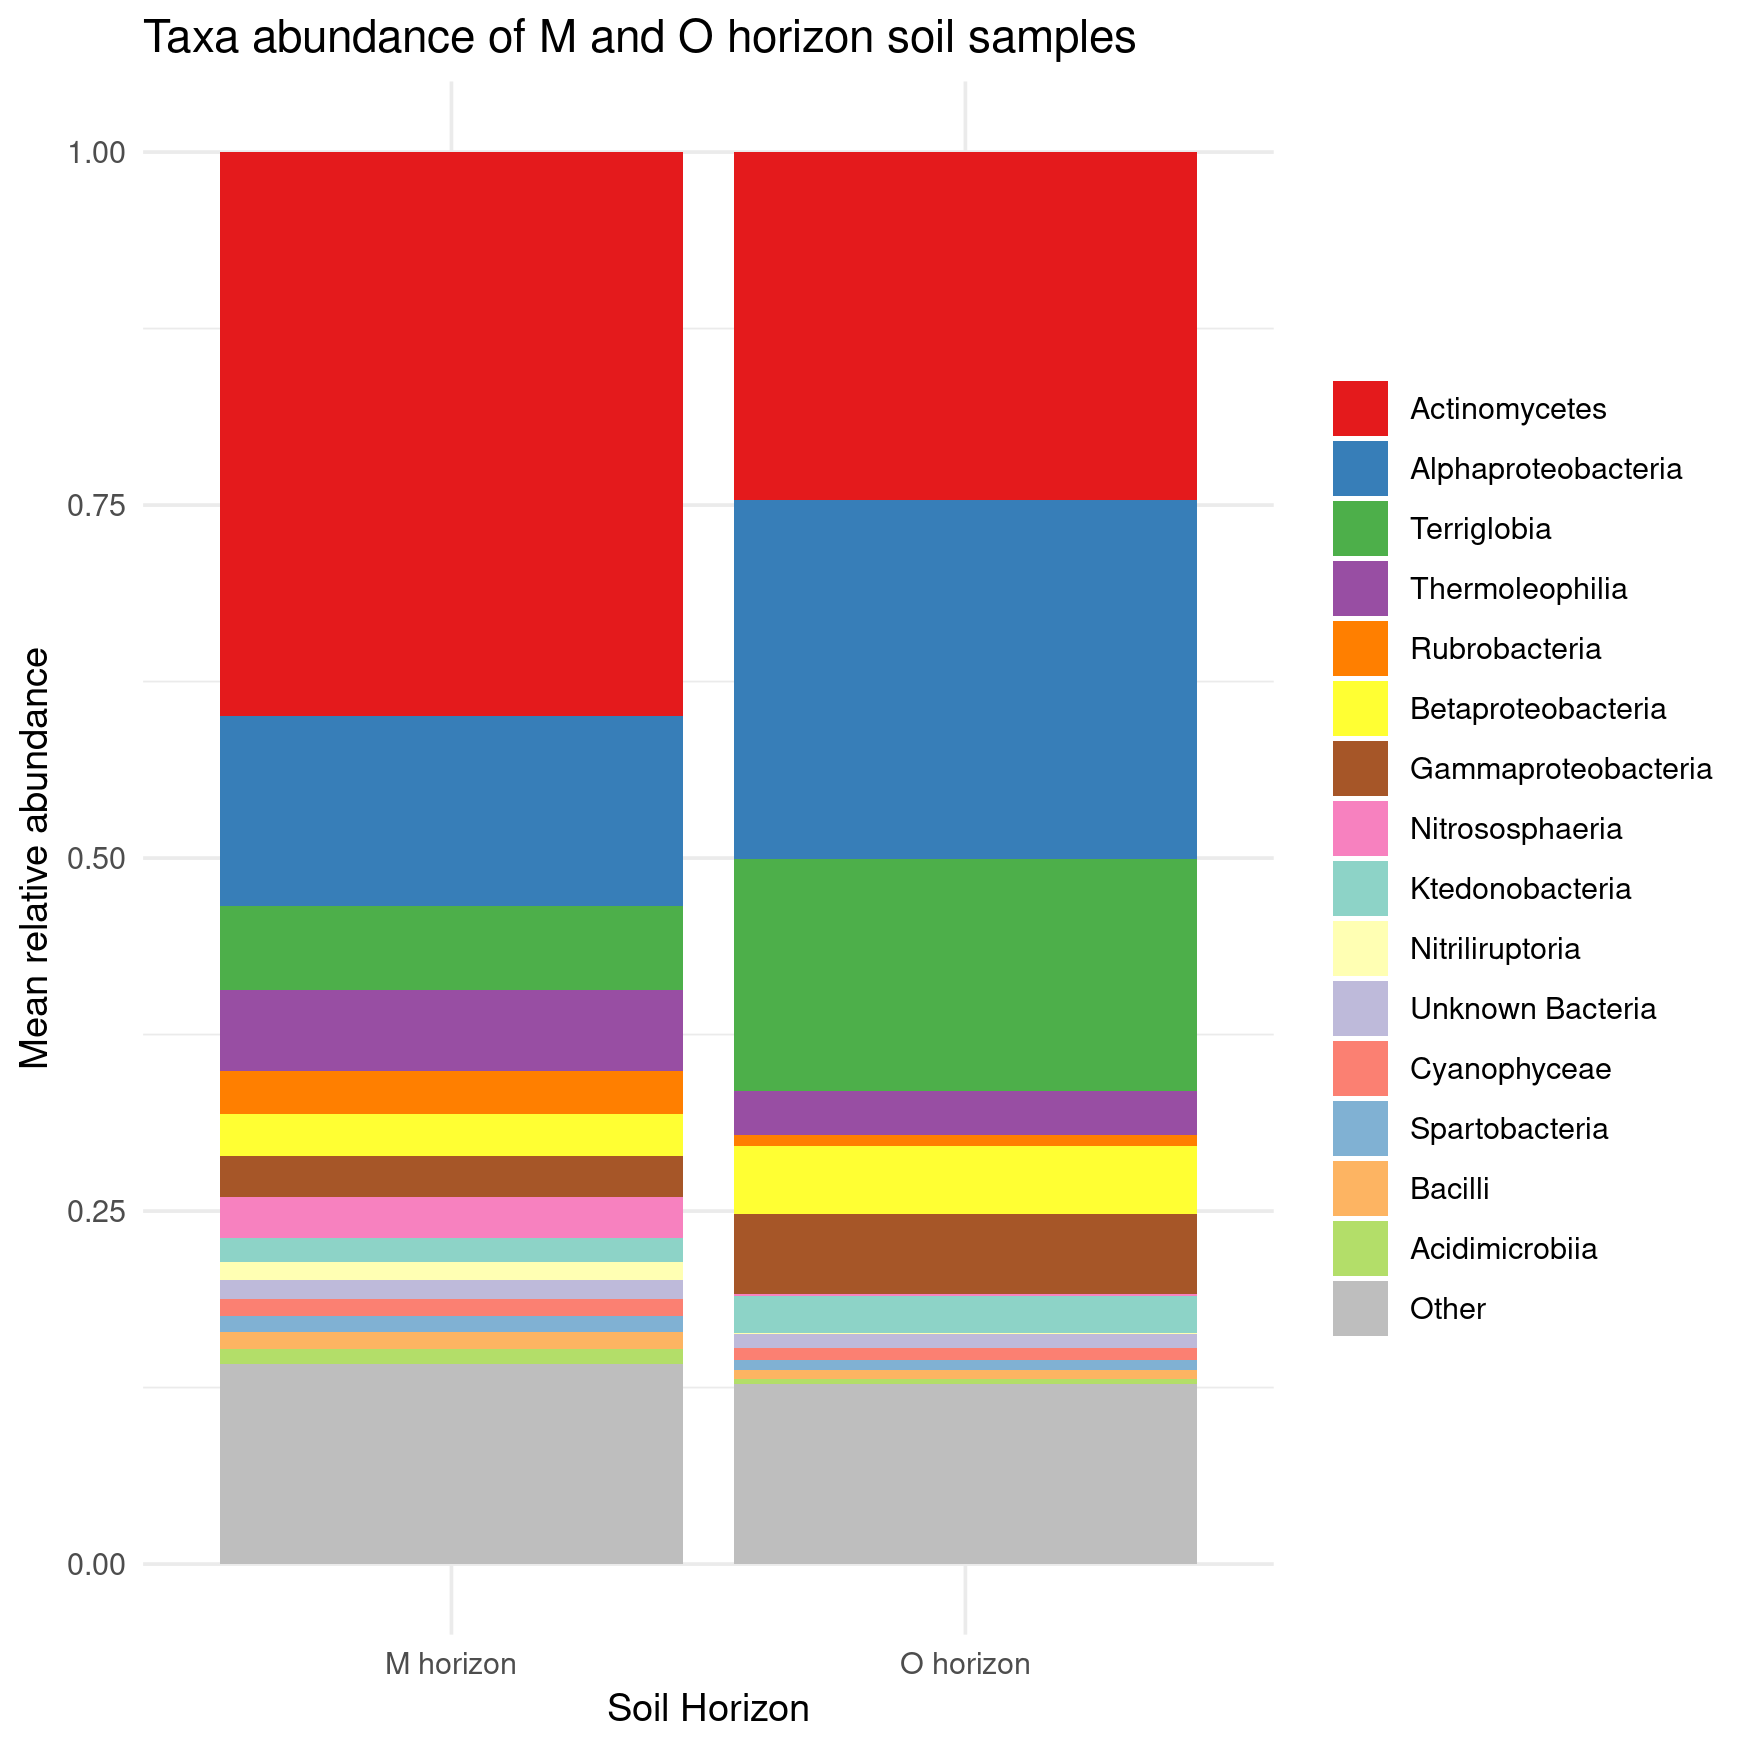

In [27]:
options(dplyr.summarise.inform = FALSE)
horizon_taxa <- biosample_taxa_df %>%
    group_by(soil_horizon, taxa) %>%
    summarise(mean_relative_abundance = mean(relative_abundance))%>%
    arrange(mean_relative_abundance) %>%
    mutate(taxa = factor(taxa, levels = rev(unique(taxa)))) %>%
    mutate(taxa_lump = forcats::fct_other(taxa, keep = levels(taxa)[1:15], other_level = 'Other')) 
           
# Make color palette that is 9 colors long, and followed with grey
color_pal <- c(RColorBrewer::brewer.pal(8, 'Set1'), RColorBrewer::brewer.pal(7, 'Set3'), 'grey')
g <- ggplot(horizon_taxa, aes(x = soil_horizon, y = mean_relative_abundance, fill = taxa_lump)) +
    geom_bar(stat = 'identity', color = NA) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = 'Taxa abundance of M and O horizon soil samples',
         x = 'Soil Horizon', y = 'Mean relative abundance', fill = NULL) +
    scale_fill_manual(values = color_pal) +
    theme_minimal() 
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 250)
g

## Plot the taxa abundance of M and O horizon soil samples for each location
First we'll pull out the top ten taxa and lump all others into an "Other" category for plotting purposes using the `forcats::fct_other` function.  Then we'll calculate the mean relative abundance of each taxa for each soil horizon for each location. Finally, we'll plot the relative abundance of each taxa for each soil horizon at each location (using the same color palette as above).

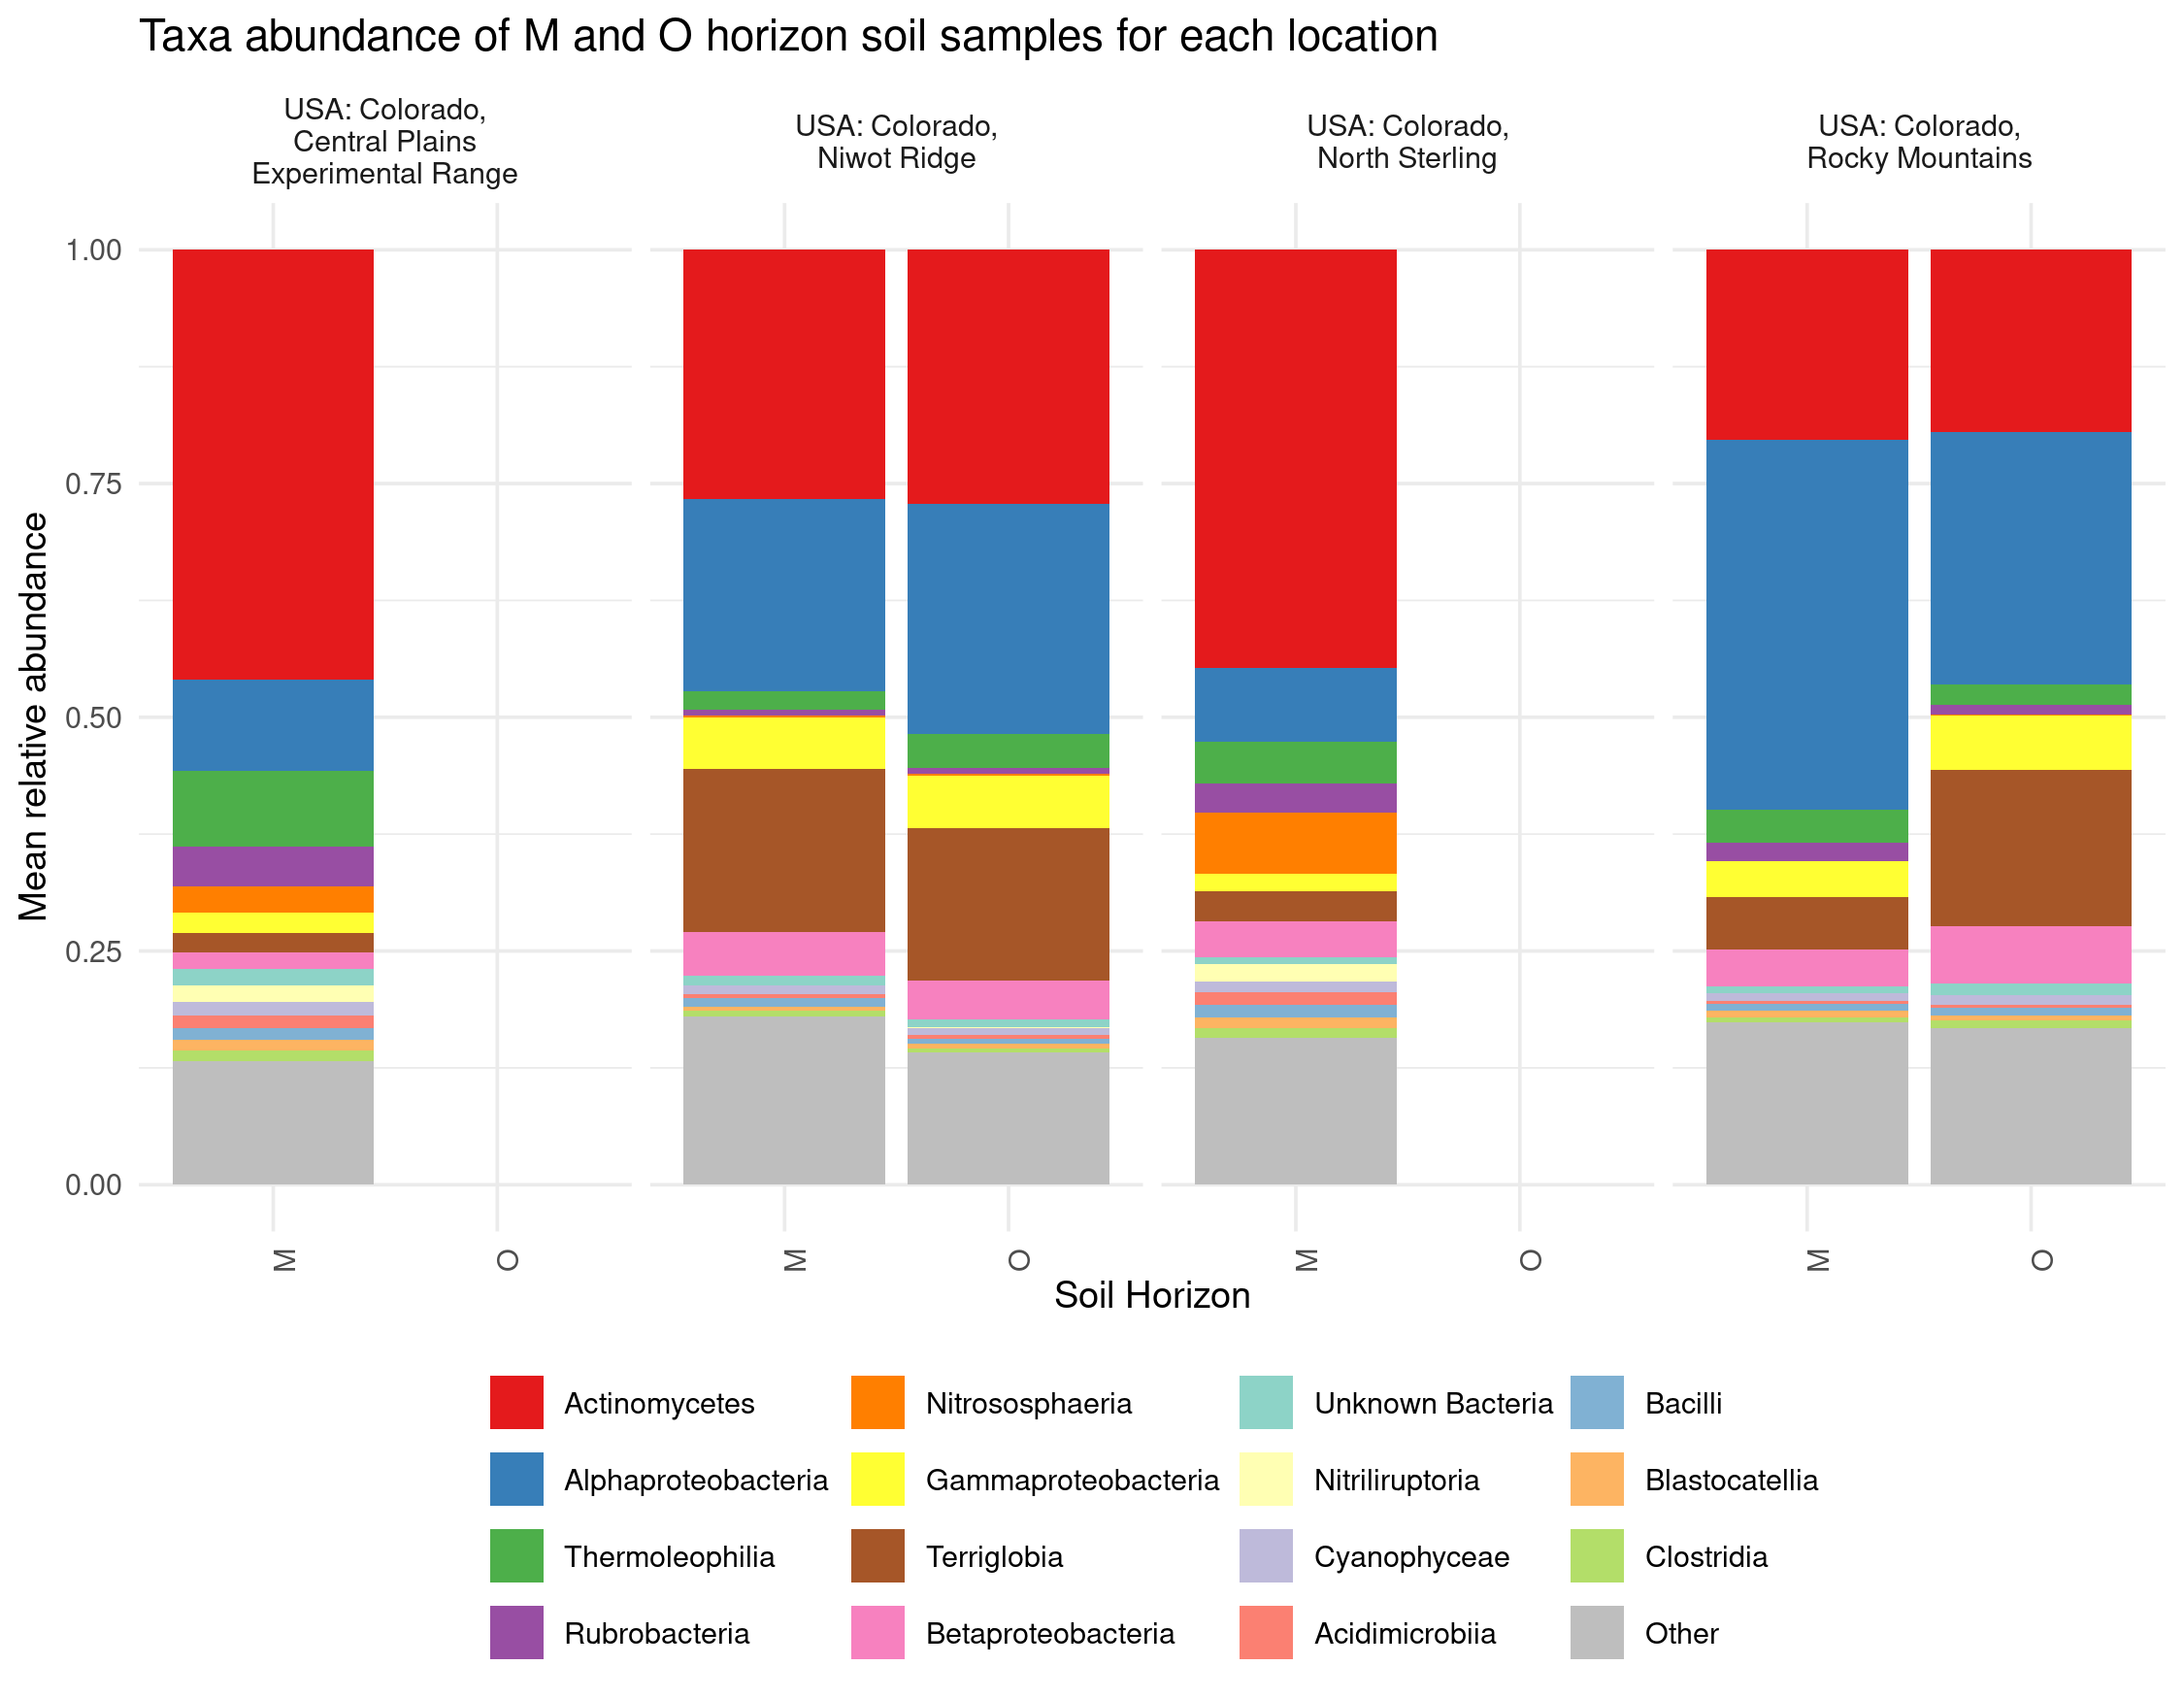

In [28]:
geo_taxa <- biosample_taxa_df %>%
    group_by(geo_loc_name, soil_horizon, taxa) %>%
    summarise(mean_relative_abundance = mean(relative_abundance)) %>%
    arrange(mean_relative_abundance) %>%
    mutate(taxa = factor(taxa, levels = rev(unique(taxa)))) %>%
    mutate(taxa_lump = forcats::fct_other(taxa, keep = levels(taxa)[1:15], other_level = 'Other')) %>%
    mutate(soil_horizon = factor(soil_horizon, levels = c('M horizon', 'O horizon'), labels = c('M', 'O')))

g <- ggplot(geo_taxa, aes(x = soil_horizon, y = mean_relative_abundance, fill = taxa_lump)) +
    geom_bar(stat = 'identity', color = NA) +
    facet_wrap(~geo_loc_name, nrow = 1,labeller =  label_wrap_gen(width = 20, multi_line = TRUE)) +
    labs(title = 'Taxa abundance of M and O horizon soil samples for each location',
         x = 'Soil Horizon', y = 'Mean relative abundance', fill = NULL) +
    scale_fill_manual(values = color_pal) +
    theme_minimal()+
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          legend.position = "bottom") 
options(repr.plot.width = 9, repr.plot.height = 7, repr.plot.res = 250)
g